In [1]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [3]:
torch.cuda.empty_cache()

In [4]:
transfrom_model = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomAffine(0, translate = (0.1, 0.1)),
    transforms.ToTensor(),
])

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root = '.', train = True, transform = transfrom_model, download = True)
test_dataset = torchvision.datasets.CIFAR10(root = '.', train = False, transform = transfrom_model, download = True)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 128, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 128, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [7]:
train_dataset.data.max()

255

In [8]:
num_classes = len(set(train_dataset.targets))
num_classes

10

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        self.flatten = nn.Flatten(1)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = F.dropout(x, p = 0.2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p = 0.2)
        out = self.fc2(x)
        return out

In [10]:
model = CNN(num_classes = num_classes)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv3

In [12]:
from torchsummary import summary
summary_model = summary(model, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 16, 16]          --
|    └─Conv2d: 2-1                       [-1, 32, 32, 32]          896
|    └─ReLU: 2-2                         [-1, 32, 32, 32]          --
|    └─BatchNorm2d: 2-3                  [-1, 32, 32, 32]          64
|    └─Conv2d: 2-4                       [-1, 32, 32, 32]          9,248
|    └─ReLU: 2-5                         [-1, 32, 32, 32]          --
|    └─BatchNorm2d: 2-6                  [-1, 32, 32, 32]          64
|    └─MaxPool2d: 2-7                    [-1, 32, 16, 16]          --
├─Sequential: 1-2                        [-1, 64, 8, 8]            --
|    └─Conv2d: 2-8                       [-1, 64, 16, 16]          18,496
|    └─ReLU: 2-9                         [-1, 64, 16, 16]          --
|    └─BatchNorm2d: 2-10                 [-1, 64, 16, 16]          128
|    └─Conv2d: 2-11                      [-1, 64, 16, 16]          36,928
| 

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
total_len = (len(train_loader)) * 2 + len(test_loader)
total_len

861

In [15]:
n_epochs = 15
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)
train_accuracies = np.zeros(n_epochs)
test_accuracies = np.zeros(n_epochs)

for epoch in range(n_epochs):
    epoch_str = str(epoch + 1).rjust(len(str(n_epochs)), " ")
    with tqdm(total = total_len, desc = f"Epoch [ {epoch_str}/{n_epochs} ] : ") as pbar:
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            pbar.update(1)

        n_correct = 0
        n_total = 0
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs_train = model(inputs)
            _, predictions_train = torch.max(outputs_train, 1)
            n_correct += (predictions_train == targets).sum().item()
            n_total += targets.shape[0]
            loss_train = criterion(outputs_train, targets)
            train_loss.append(loss_train.item())
            pbar.update(1)

        train_acc_epoch = n_correct / n_total
        train_loss = np.mean(train_loss)
        train_losses[epoch] = train_loss
        train_accuracies[epoch] = train_acc_epoch

        n_correct = 0
        n_total = 0
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs_test = model(inputs)
            _, predictions_test = torch.max(outputs_test, 1)
            n_correct += (predictions_test == targets).sum().item()
            n_total += targets.shape[0]
            loss_test = criterion(outputs_test, targets)
            test_loss.append(loss_test.item())
            pbar.update(1)

        test_acc_epoch = n_correct / n_total
        test_loss = np.mean(test_loss)
        test_losses[epoch] = test_loss
        test_accuracies[epoch] = test_acc_epoch
        pbar.set_description(f"Epoch [ {epoch_str}/{n_epochs} ] ")
        pbar.set_postfix({'Train Accuracy' : f"{train_acc_epoch:.4f}", 'Train Loss' : f"{train_loss:.4f}", 'Test Accuracy' : f"{test_acc_epoch:.4f}", 'Test Loss' : f"{test_loss:.4f}"})

Epoch [ 15/15 ] : 100%|██████████| 861/861 [00:17<00:00, 47.89it/s, Train Accuracy=0.8691, Train Loss=0.3790, Test Accuracy=0.8307, Test Loss=0.5027]


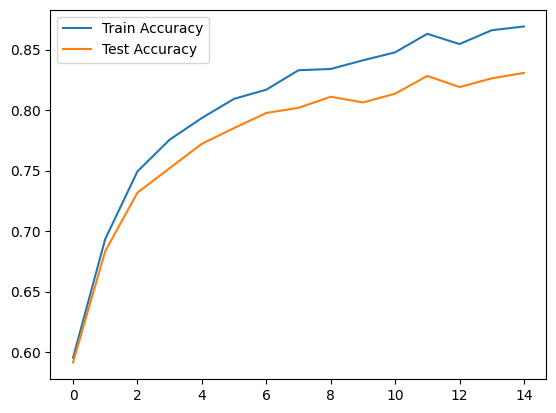

In [16]:
plt.plot(train_accuracies, label = 'Train Accuracy')
plt.plot(test_accuracies, label = 'Test Accuracy')
plt.legend()
plt.show()

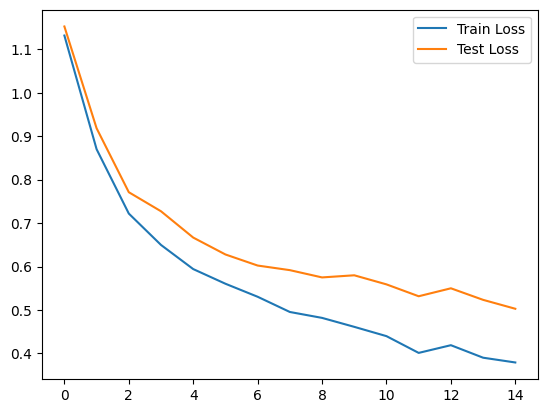

In [17]:
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.show()

In [18]:
n_correct = 0
n_total = 0
with tqdm(total = (len(train_loader) + len(test_loader)), desc = "Calculating accuracies : ") as pbar:
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs_train_final = model(inputs)
        _, predictions_train_final = torch.max(outputs_train_final, 1)
        n_correct += (predictions_train_final == targets).sum().item()
        n_total += targets.shape[0]
        pbar.update(1)

    train_acc = n_correct / n_total

    n_correct = 0
    n_total = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs_test_final = model(inputs)
        _, predictions_test_final = torch.max(outputs_test_final, 1)
        n_correct += (predictions_test_final == targets).sum().item()
        n_total += targets.shape[0]
        pbar.update(1)

    test_acc = n_correct / n_total
    pbar.set_description("Process completed ")
    # pbar.set_postfix_str(f"Train Accuracy : {train_acc:.4f}, Test Accuracy : {test_acc:.4f}")  
    print(f"\nTrain Accuracy : {train_acc:.4f}, Test Accuracy : {test_acc:.4f}")

Process completed : 100%|██████████| 470/470 [00:11<00:00, 41.43it/s]     


Train Accuracy : 0.8694, Test Accuracy : 0.8332


In [19]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[881   9  29  14  10   1   2   7  30  17]
 [ 16 892   2   5   0   2   2   1  10  70]
 [ 60   1 726  65  52  40  36  15   3   2]
 [ 25   4  43 686  46 131  40  13   3   9]
 [ 12   0  41  38 833  31  14  25   3   3]
 [  5   1  21 139  23 772  11  21   1   6]
 [  9   3  38  47  19  10 866   4   2   2]
 [ 14   0  14  35  33  54   4 838   2   6]
 [ 73  12   6  14   1   1   9   3 857  24]
 [ 27  27   2   9   1   2   2   3  16 911]]


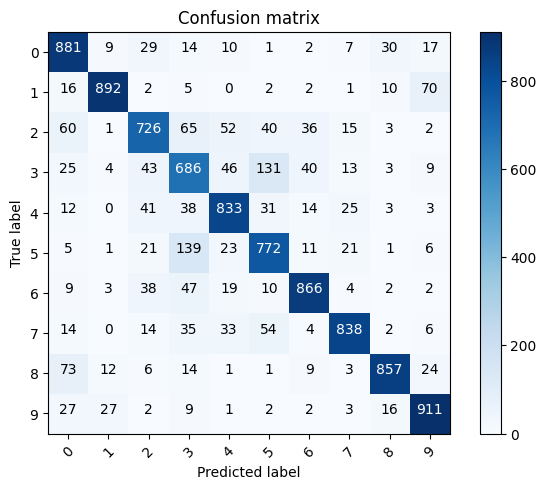

In [20]:
x_test = test_dataset.data
y_test = np.array(test_dataset.targets)
p_test = np.array([])

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    outputs_cm = model(inputs)
    _, prediction_cm = torch.max(outputs_cm, 1)
    p_test = np.concatenate((p_test, prediction_cm.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [21]:
labels = test_dataset.classes

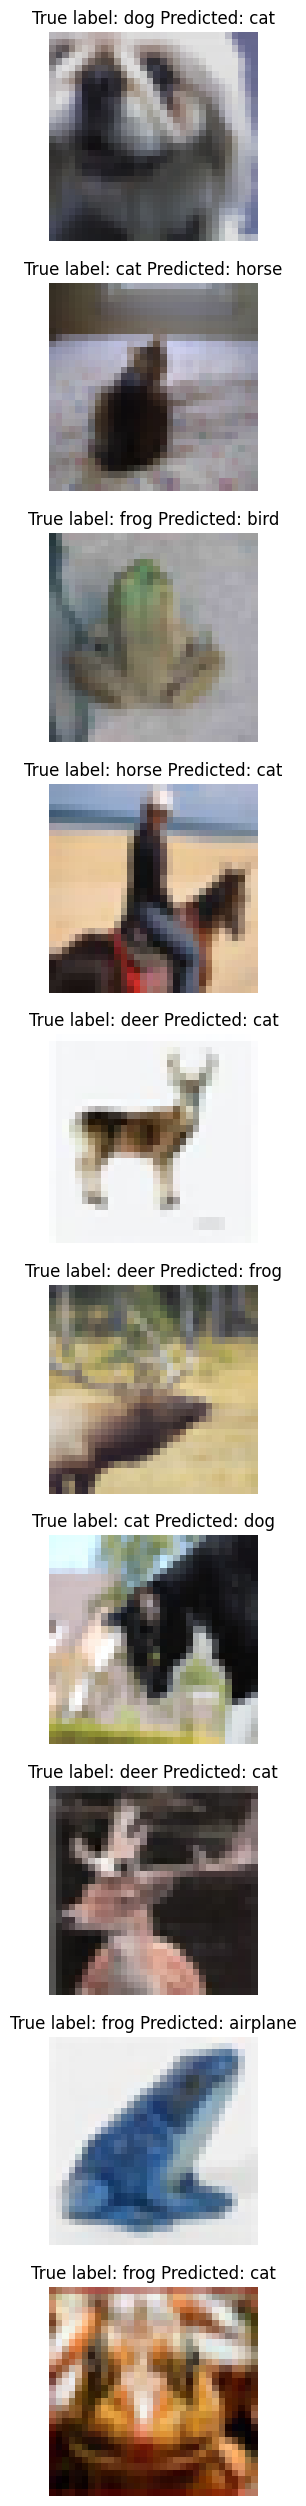

In [22]:
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
sample_idx = np.random.choice(misclassified_idx, 10, replace=False)
plt.figure(figsize=(32,32))
for j, i in enumerate(sample_idx):
  plt.subplot(10, 1, j + 1)
  plt.axis('off')
  plt.imshow(x_test[i].reshape(32,32,3))
  plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));